In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import Callback
import numpy as np
from tqdm import tqdm
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

NUM_CLASS = 2
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 3

In [2]:
# Define paths to the train and test directories
train_dir = 'data_tile/train'
val_dir = 'data_tile/val'
test_dir = 'data_tile/test'

In [3]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
 )

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
steps_per_epoch_test = len(test_generator)

Found 219 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


Model Training and Validation

In [4]:
resnet50_model = Sequential()
# Add ResNet50 base model (without the top classification layers)
#resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))
resnet50_model.add(layers.Dense(NUM_CLASS, activation='softmax'))

# since pre-trained model already trained so we dont need to train it again
resnet50_model.layers[0].trainable = False

resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
resnet50_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_generator, steps):
        super().__init__()
        self.test_generator = test_generator
        self.steps = steps
        self.test_accuracies = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        results = self.model.evaluate(self.test_generator, steps=self.steps, verbose=0)
        self.test_losses.append(results[0])  # Loss
        self.test_accuracies.append(results[1])  # Accuracy
        print(f"\nTest Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}")


In [6]:
test_callback = TestCallback(test_generator, steps_per_epoch_test)

resnet50_history = resnet50_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation // BATCH_SIZE,
    callbacks=[test_callback],  # Add TestCallback here
    verbose=1,
)

Epoch 1/3


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6490 - loss: 0.6523
Test Loss: 0.4031, Test Accuracy: 0.7857
7/7 ━━━━━━━━━━━━━━━━━━━━ 130s 12s/step - accuracy: 0.6581 - loss: 0.6375 - val_accuracy: 0.7692 - val_loss: 0.3352
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8168 - loss: 0.3372
Test Loss: 0.2674, Test Accuracy: 0.8929
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 10s/step - accuracy: 0.8220 - loss: 0.3333 - val_accuracy: 0.8462 - val_loss: 0.2296
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9580 - loss: 0.2023
Test Loss: 0.1901, Test Accuracy: 0.9643
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 10s/step - accuracy: 0.9569 - loss: 0.2022 - val_accuracy: 0.9615 - val_loss: 0.1800


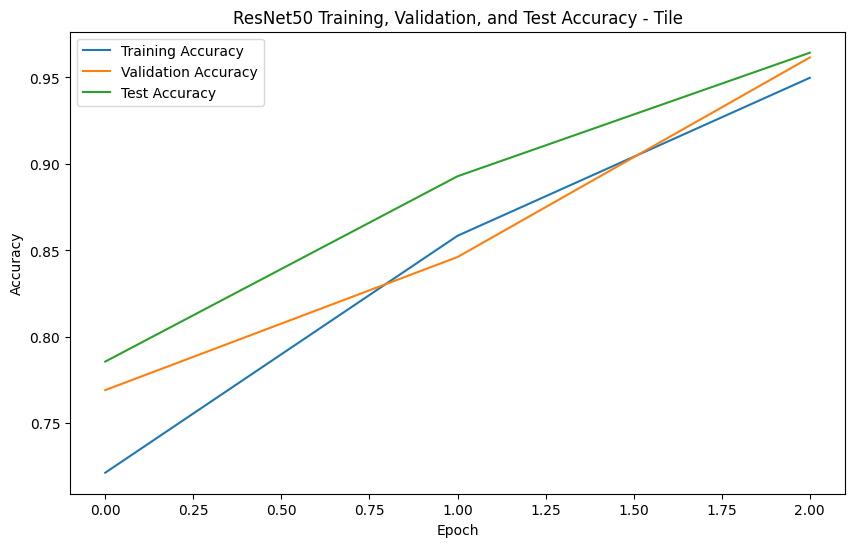

In [7]:
# Assuming test_callback is the instance of TestCallback used during training
plt.figure(figsize=(10, 6))
plt.plot(resnet50_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(test_callback.test_accuracies, label='Test Accuracy')  # Use test_callback instance

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet50 Training, Validation, and Test Accuracy - Tile')
plt.legend()
plt.show()

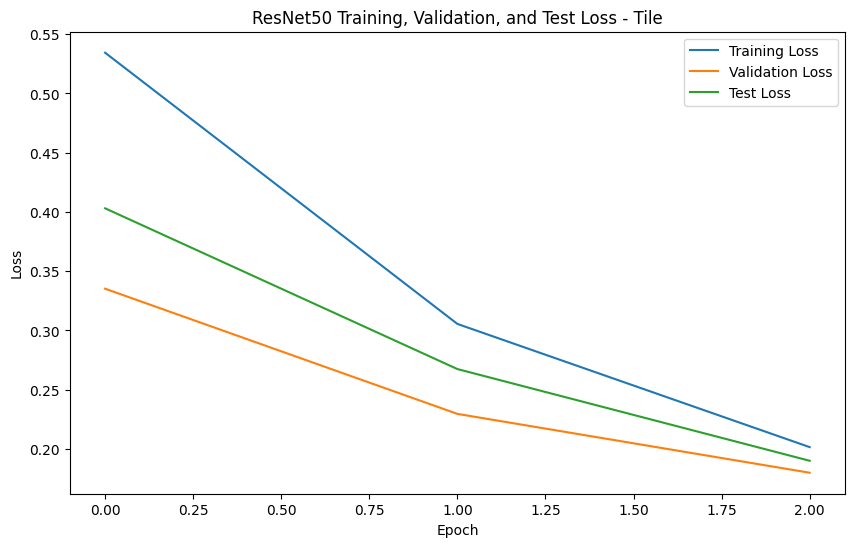

In [8]:
# Assuming test_losses are collected using the TestCallback class

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(resnet50_history.history['loss'], label='Training Loss')
plt.plot(resnet50_history.history['val_loss'], label='Validation Loss')
plt.plot(test_callback.test_losses, label='Test Loss')  # Assuming TestCallback is the first callback

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet50 Training, Validation, and Test Loss - Tile')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


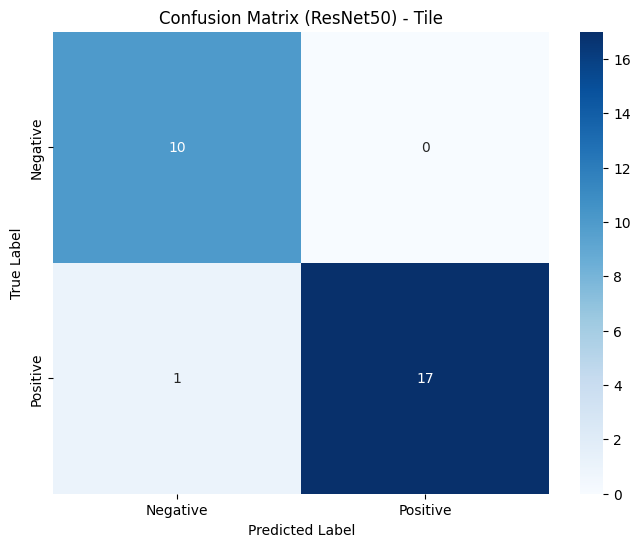

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict classes for test data
y_pred = resnet50_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True classes for test data
true_classes = test_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (ResNet50) - Tile')
plt.show()

In [10]:
import pandas as pd
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_classes, y_pred_classes, target_names=class_labels, output_dict=True)

# Extract precision, recall, and F1-score for each class
metrics_df = pd.DataFrame(report).transpose()

# Select relevant columns
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# Display the DataFrame
print(metrics_df)

              precision    recall  f1-score
Negative       0.909091  1.000000  0.952381
Positive       1.000000  0.944444  0.971429
accuracy       0.964286  0.964286  0.964286
macro avg      0.954545  0.972222  0.961905
weighted avg   0.967532  0.964286  0.964626


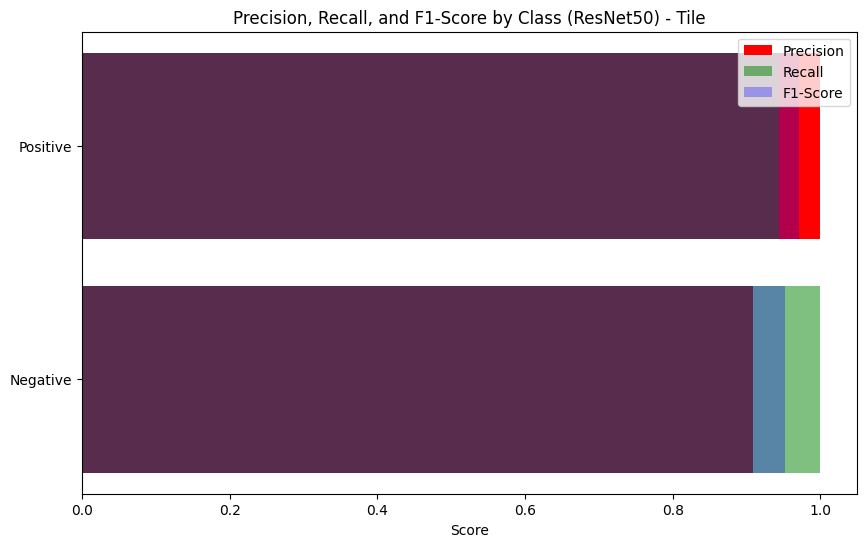

In [11]:
# Generate classification report
report = classification_report(true_classes, y_pred_classes, target_names=class_labels, output_dict=True)

# Extract precision, recall, and F-measure for each class
precision = [report[label]['precision'] for label in class_labels]
recall = [report[label]['recall'] for label in class_labels]
f1_score = [report[label]['f1-score'] for label in class_labels]

# Plot matrix diagram
plt.figure(figsize=(10, 6))
plt.barh(class_labels, precision, color='r', label='Precision')
plt.barh(class_labels, recall, color='g', label='Recall', alpha=0.5)
plt.barh(class_labels, f1_score, color='b', label='F1-Score', alpha=0.3)
plt.xlabel('Score')
plt.title('Precision, Recall, and F1-Score by Class (ResNet50) - Tile')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9643 - loss: 0.1901
Test Loss: 0.19006767868995667
Test Accuracy: 0.9642857313156128


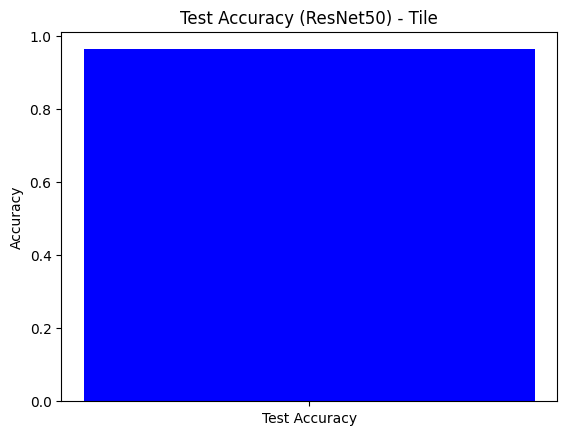

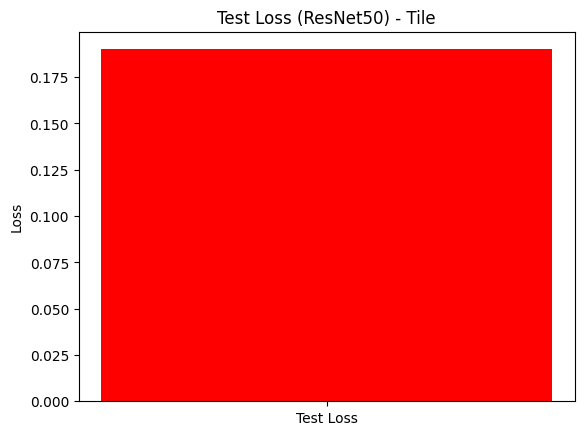

In [12]:
# Evaluate the model on the test data
test_loss, test_acc = resnet50_model.evaluate(test_generator, steps=steps_per_epoch_test)

# Print test accuracy and loss
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

# Plot test accuracy
plt.figure()
plt.bar(['Test Accuracy'], [test_acc], color='blue')
plt.ylabel('Accuracy')
plt.title('Test Accuracy (ResNet50) - Tile')
plt.show()

# Plot test loss
plt.figure()
plt.bar(['Test Loss'], [test_loss], color='red')
plt.ylabel('Loss')
plt.title('Test Loss (ResNet50) - Tile')
plt.show()

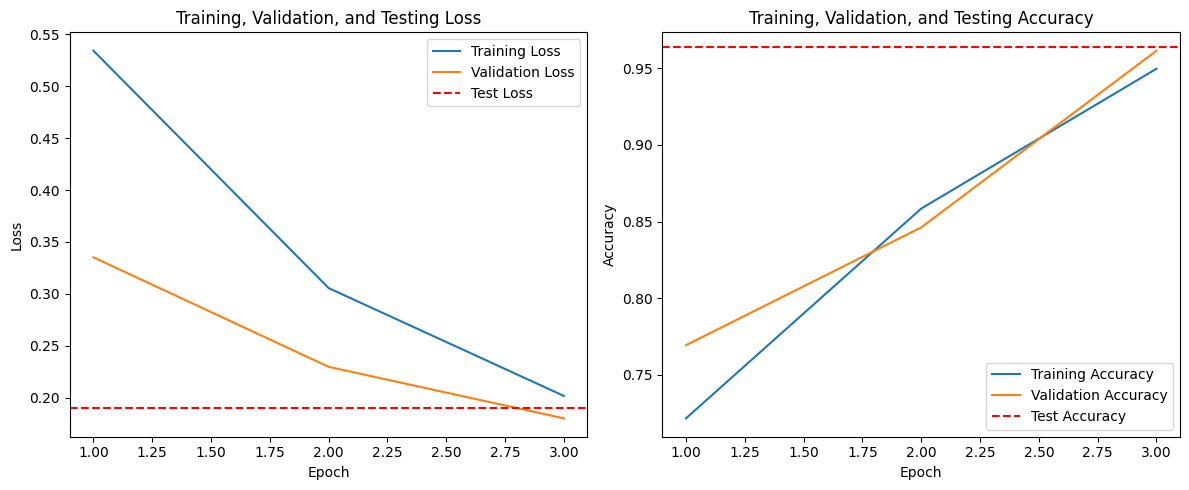

In [13]:
epochs = range(1, EPOCHS + 1)

# Plot: Testing Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot for Testing Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, resnet50_history.history['loss'], label='Training Loss')
plt.plot(epochs, resnet50_history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Testing Loss')
plt.legend()

# Plot for Testing Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, resnet50_history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, resnet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Testing Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [14]:
# Save the trained model to a file
model_save_path = 'tile_resnet50_model.h5'
resnet50_model.save(model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to tile_resnet50_model.h5


TESTING

In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Reload the saved model
model_path = 'tile_resnet50_model.h5'
loaded_model = load_model(model_path)
print(f"Model loaded from {model_path}")

Model loaded from tile_resnet50_model.h5


In [16]:
# Directory containing raw_concrete dataset
test_data_dir = 'raw_tile'

# Image data generator for preprocessing the test data
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create the test generator
test_generator2 = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,  # Ensure predictions align with true labels
    class_mode='categorical'
)

# Predict on the test data
test_steps = len(test_generator2)
predictions = loaded_model.predict(test_generator2, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'raw_tile'

In [18]:
# True labels
true_classes = test_generator2.classes

# Class labels
class_labels = list(test_generator2.class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

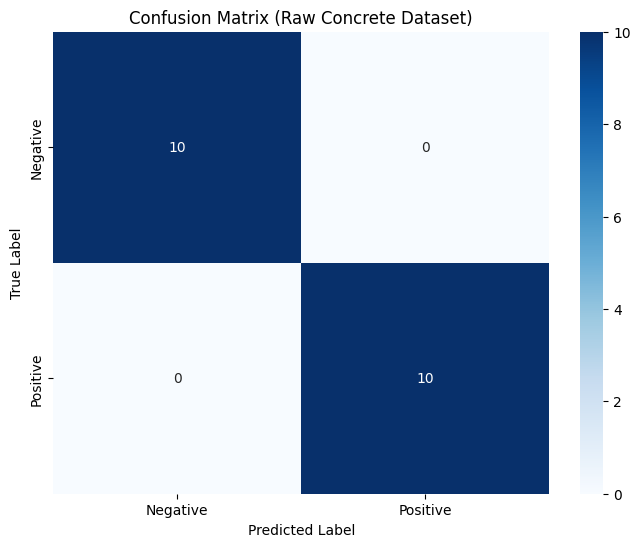

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Raw Concrete Dataset)')
plt.show()

In [20]:
# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        10
    Positive       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



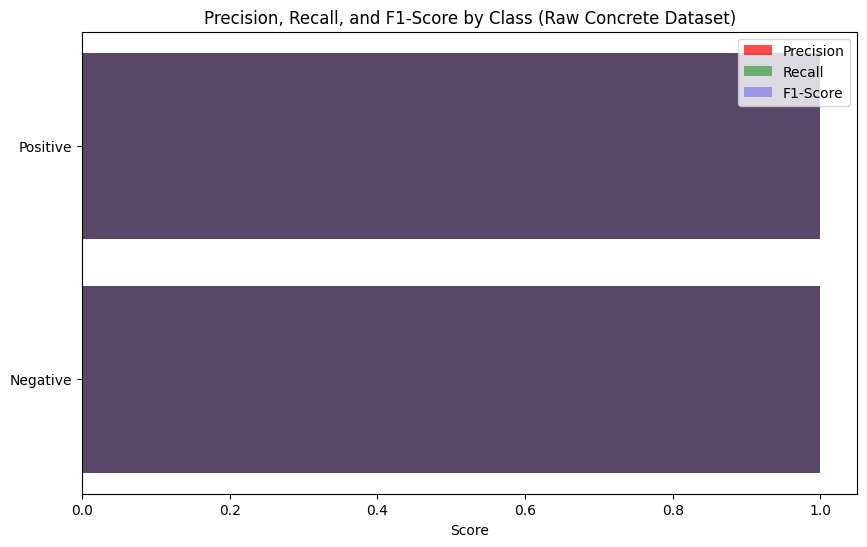

In [ ]:
# Extract precision, recall, and F1-score
report_dict = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
precision = [report_dict[label]['precision'] for label in class_labels]
recall = [report_dict[label]['recall'] for label in class_labels]
f1_score = [report_dict[label]['f1-score'] for label in class_labels]

# Plot precision, recall, and F1-score for each class
plt.figure(figsize=(10, 6))
plt.barh(class_labels, precision, color='r', alpha=0.7, label='Precision')
plt.barh(class_labels, recall, color='g', alpha=0.5, label='Recall')
plt.barh(class_labels, f1_score, color='b', alpha=0.3, label='F1-Score')
plt.xlabel('Score')
plt.title('Precision, Recall, and F1-Score by Class (Raw Tile Dataset)')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.1297
Test Loss: 0.1297
Test Accuracy: 1.0000


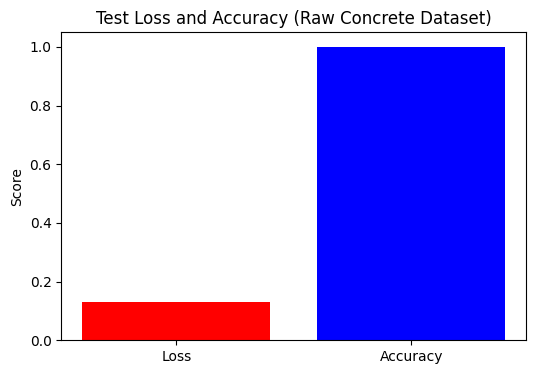

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = loaded_model.evaluate(test_generator2, steps=len(test_generator2))

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot test metrics
test_metrics = {'Loss': test_loss, 'Accuracy': test_accuracy}

plt.figure(figsize=(6, 4))
plt.bar(test_metrics.keys(), test_metrics.values(), color=['red', 'blue'])
plt.ylabel('Score')
plt.title('Test Loss and Accuracy (Raw Tile Dataset)')
plt.show()


T2